In [1]:
dirc_path = '/home/habjan.e/'

import sys
sys.path.append(dirc_path + "TNG/TNG_cluster_dynamics")
import TNG_DA
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from IPython.display import display, Markdown
from astropy.io import fits
from astropy.table import Table
import pickle

import os
sys.path.append(os.getcwd())
from training_structure import train_model, predict

import jraph
import jax.numpy as jnp
import jax.nn as jnn

### Import parameters

In [39]:
suffix_jax = '_testing_newdata'

save_path = os.getcwd() + '/GNN_models/gnn_model_params' + suffix_jax + '.pkl'

save_path = '/home/habjan.e/TNG/Sandbox_notebooks/phase_space_recon/GNN_models/gnn_model_params_norm_grid_layer.pkl'
suffix_jax = '_norm_grid_layer'

with open(save_path, 'rb') as f:
    loaded_params = pickle.load(f)

### Import model

In [40]:
import sys
sys.path.append(os.getcwd())
from gnn import GraphConvNet

latent_size = 128

model = GraphConvNet(latent_size = latent_size, 
                         hidden_size = 1024, 
                         num_mlp_layers = 3, 
                         message_passing_steps = 5, 
                         skip_connections = True,
                         edge_skip_connections = True,
                         norm = "none", 
                         attention = True,
                         shared_weights = True,
                         relative_updates = False,
                         output_dim = 2,
                         dropout_rate = 0.0)

### Pick a cluster to look at

In [41]:
cluster_ind = 20

pos, vel, groups, subhalo_masses, submass_type, h, halo_mass = TNG_DA.get_cluster_props(cluster_ind)

vel = vel - np.mean(vel, axis = 0)

tng_stellar = submass_type[:, 4]

Cluster 20 has a $M_{200}$ less than 15.0 $\log(M_\odot)$

### Define some functions that will be used to make classifications

In [43]:
LATENT_SIZE = 128
KNN_K = 16

def make_graph(nodes_np: np.ndarray, eps: float = 1e-6) -> jraph.GraphsTuple:
    """Convert (N, 3) numpy array -> GraphsTuple."""

    nodes = jnp.asarray(nodes_np, dtype=jnp.float32)
    N = nodes.shape[0]

    xyzv = nodes[:, :3]
    #mass = nodes[:, 3:4]

    # Pair-wise calculation of x, y, v_z
    diffs = xyzv[:, None, :] - xyzv[None, :, :]
    d2 = jnp.sum(diffs ** 2, axis=-1)
    d2 = d2 + jnp.eye(N, dtype=d2.dtype) * 1e9     # Adding the large identity prevents a node from selecting itself as an edge feature
    knn_idx = jnp.argsort(d2, axis=1)[:, :KNN_K]

    senders = jnp.repeat(jnp.arange(N, dtype=jnp.int32), KNN_K)
    receivers = knn_idx.reshape(-1).astype(jnp.int32)

    src_xyzv = xyzv[senders]
    dst_xyzv = xyzv[receivers]
    rel = dst_xyzv - src_xyzv
    dist = jnp.linalg.norm(rel, axis=-1, keepdims=True)

    #Mi = jnn.softplus(mass[senders]) ### Soft plus to keep the masses postive
    #Mj = jnn.softplus(mass[receivers])
    #gravity = (Mi + Mj) / (dist**2 + eps)

    #edges = jnp.concatenate([rel, dist, gravity], axis=-1)

    edges = jnp.concatenate([rel, dist], axis=-1)

    dummy_globals = jnp.zeros((1, LATENT_SIZE), dtype=jnp.float32)
    globals_ = jnp.array([[N / 700]], dtype=jnp.float32)

    return jraph.GraphsTuple(
        nodes=nodes,             
        edges=edges,
        senders=senders,
        receivers=receivers,
        n_node=jnp.array([N], dtype=jnp.int32),
        n_edge=jnp.array([edges.shape[0]],  dtype=jnp.int32),
        globals=globals_
    )

def prediction(model, params, in_graph):
    """
    Make predictions with a trained model.
    """
        
    preds = model.apply({'params': params}, in_graph, deterministic = True)

    return preds.nodes

### Make a graph for a single cluster

In [44]:
x_mean = np.nanmean(pos[:, 0])
y_mean = np.nanmean(pos[:, 1])
vz_mean = np.nanmean(vel[:, 2])
m_mean = np.nanmean(tng_stellar)

x_std = np.nanstd(pos[:, 0])
y_std = np.nanstd(pos[:, 1])
vz_std = np.nanstd(vel[:, 2])
m_std = np.nanstd(tng_stellar)

#obs_arr = np.array([(pos[:, 0] - x_mean) / x_std, (pos[:, 1] - y_mean) / y_std, (vel[:, 2] - vz_mean) / vz_std, (tng_stellar - m_mean) / m_std]).T
obs_arr = np.array([(pos[:, 0] - x_mean) / x_std, (pos[:, 1] - y_mean) / y_std, (vel[:, 2] - vz_mean) / vz_std]).T

r_ro = np.sqrt(pos[:, 0]**2 + pos[:, 1]**2 + pos[:, 2]**2)
r_ro_mean, r_ro_std = np.nanmean(r_ro), np.nanstd(r_ro)

v_ro = np.sqrt(vel[:, 0]**2 + vel[:, 1]**2 + vel[:, 2]**2)
v_ro_mean, v_ro_std = np.nanmean(v_ro), np.nanstd(v_ro)

r_ro_zscore, v_ro_zscore = (r_ro - r_ro_mean) / r_ro_std, (v_ro - v_ro_mean) / v_ro_std

cl_graph = make_graph(obs_arr)

### Predict on this single cluster

In [45]:
preds = prediction(model = model, params = loaded_params, in_graph = cl_graph)

### Compare true TNG positions/velocities with predictions

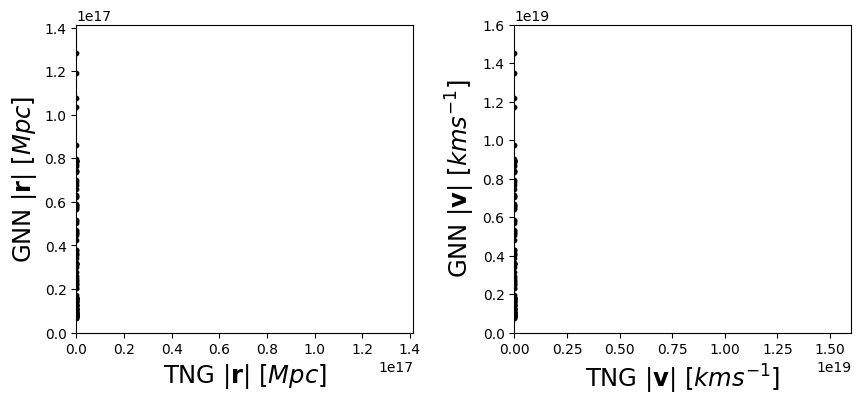

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'wspace': 0.3})

one_one = np.linspace(-10000, 10000, 100)

axs[0].scatter(r_ro_zscore * 1.25 + 2, preds[:, 0] * 1.25 + 2, c='k', s=10)
axs[0].plot(one_one, one_one, c='k', linestyle='--')
axs[0].set_xlabel(r'TNG $| \mathbf{r} |$ $\left[ Mpc \right]$', fontsize = 17.5)
axs[0].set_ylabel(r'GNN $| \mathbf{r} |$ $\left[ Mpc \right]$', fontsize = 17.5)
lims = np.concatenate([r_ro_zscore * 1.25 + 2, preds[:, 0] * 1.25 + 2])
axs[0].set_xlim(-0.1, np.max(lims)*1.1)
axs[0].set_ylim(-0.1, np.max(lims)*1.1)

axs[1].scatter(v_ro_zscore*500 + 1300, preds[:, 1]*500 + 1300, c='k', s=10)
axs[1].plot(one_one, one_one, c='k', linestyle='--')
axs[1].set_xlabel(r'TNG $| \mathbf{v} |$ $\left[ km s^{-1} \right]$', fontsize = 17.5)
axs[1].set_ylabel(r'GNN $| \mathbf{v} |$ $\left[ km s^{-1} \right]$', fontsize = 17.5)
lims = np.concatenate([v_ro_zscore*500 + 1300, preds[:, 1]*500 + 1300])
axs[1].set_xlim(np.min(lims)*0.7, np.max(lims)*1.1)
axs[1].set_ylim(np.min(lims)*0.7, np.max(lims)*1.1)

fig.savefig("/home/habjan.e/TNG/TNG_cluster_dynamics/figures/tng_predictions.png", bbox_inches="tight")
plt.show()

### Import loss arrays

In [47]:
data_path = '/home/habjan.e/TNG/Sandbox_notebooks/phase_space_recon/Loss_arrays/'

test_loss = np.load(data_path + 'test_loss' + suffix_jax + '.npy')
train_loss = np.load(data_path + 'train_loss' + suffix_jax + '.npy')

test_log = 25
test_fac = 10
test_loss_plot = np.array([np.nanmedian(test_loss[i:i+test_fac]) for i in range(0, test_loss.shape[0], test_fac)])
test_batches = np.arange((test_log * test_fac), (len(test_loss_plot) + 1) * (test_log * test_fac), (test_log * test_fac))

train_log = 250
train_loss_plot = np.array([np.nanmedian(train_loss[i:i+train_log]) for i in range(0, train_loss.shape[0], train_log)])
train_batches = np.arange(1, (len(train_loss) + 1), train_log)

### Plot losses

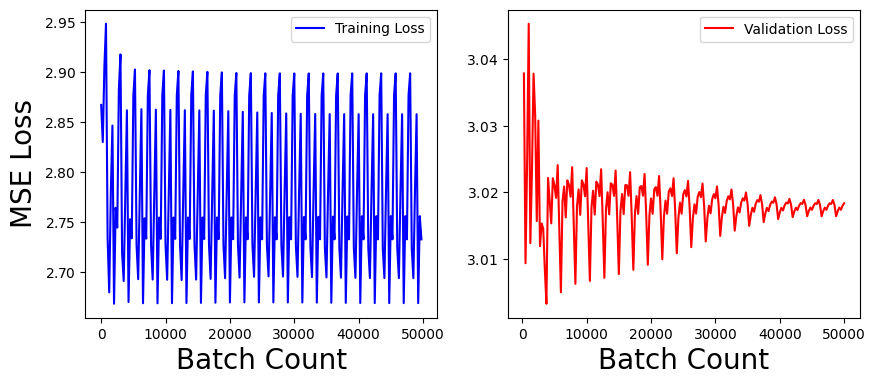

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'wspace': 0.2})

axs[0].plot(train_batches, train_loss_plot, color = 'blue', label = 'Training Loss')
axs[1].plot(test_batches, test_loss_plot, color = 'red', label = 'Validation Loss')

axs[0].set_xlabel('Batch Count', fontsize = 20)
axs[1].set_xlabel('Batch Count', fontsize = 20)
axs[0].set_ylabel(r'MSE Loss', fontsize = 20)

#axs[0].set_yscale('symlog', linthresh=10**-3)
#axs[1].set_yscale('symlog', linthresh=10**-3)

for ax in axs:
    fmt = ScalarFormatter(useMathText=True)
    fmt.set_scientific(True)
    fmt.set_powerlimits((0, 0))
    fmt.set_useOffset(False)
    ax.yaxis.set_major_formatter(fmt)

axs[0].legend()
axs[1].legend()

#fig.savefig("/home/habjan.e/TNG/TNG_cluster_dynamics/figures/loss_curves.png", bbox_inches="tight")
plt.show()

### Make arrays to look at the learning rate

In [49]:
import numpy as np
import jax
import jax.numpy as jnp
import optax

num_train_steps = 50_000
schedule = optax.cosine_decay_schedule(
    init_value=1e-3,
    decay_steps=int(num_train_steps * 0.9),
    alpha=0.1,
)

# Steps 0..num_train_steps-1
steps = jnp.arange(num_train_steps, dtype=jnp.int32)

# Evaluate schedule at each step (JAX array)
lr_jax = jax.vmap(schedule)(steps)

# Convert to a NumPy array on host
lr_np = np.asarray(lr_jax)


train_log_2 = 500
train_loss_plot_2 = np.array([np.nanmedian(train_loss[i:i+train_log_2]) for i in range(0, train_loss.shape[0], train_log_2)])
lr_np_plot = np.array([np.nanmedian(lr_np[i:i+train_log_2]) for i in range(0, lr_np.shape[0], train_log_2)])


test_log_2 = 25
test_fac = 10
test_loss_plot_2 = np.array([np.nanmedian(test_loss[i:i+test_fac]) for i in range(0, test_loss.shape[0], test_fac)])
test_batches = np.arange((test_log * test_fac), (len(test_loss_plot_2) + 1) * (test_log * test_fac), (test_log * test_fac))
lr_np_plot_2 = np.array([np.nanmedian(lr_np[i:i+(test_log_2 * test_fac)]) for i in range(0, lr_np.shape[0], (test_log_2 * test_fac))])

### Compare losses with the learning rate

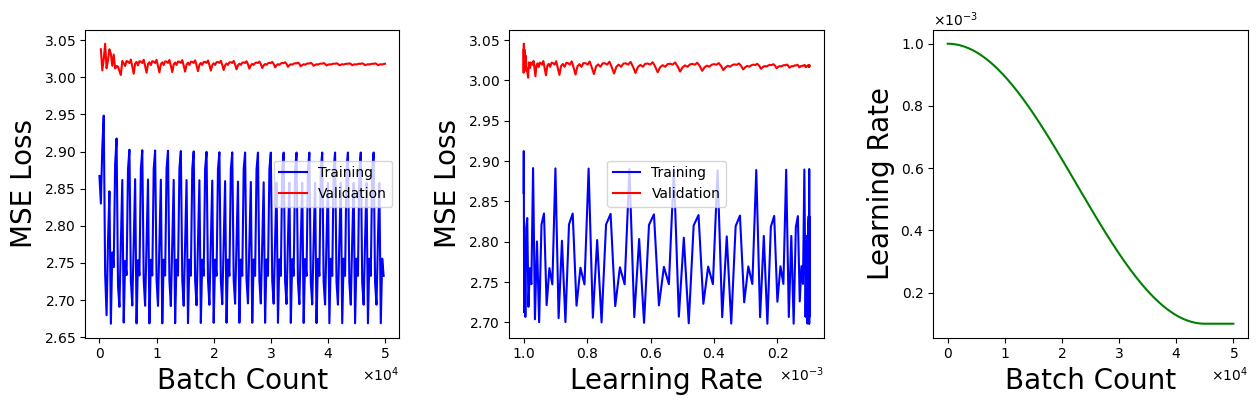

In [50]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), gridspec_kw={'wspace': 0.35})

axs[0].plot(train_batches, train_loss_plot, color = 'blue', label = 'Training')
axs[0].plot(test_batches, test_loss_plot_2, color = 'red', label = 'Validation')

axs[1].plot(lr_np_plot, train_loss_plot_2, color = 'blue', label = 'Training')
axs[1].plot(lr_np_plot_2, test_loss_plot_2, color = 'red', label = 'Validation')

axs[2].plot(steps, lr_np, color = 'green')

axs[0].set_xlabel('Batch Count', fontsize = 20)
axs[0].set_ylabel(r'MSE Loss', fontsize = 20)

axs[1].set_ylabel('MSE Loss', fontsize = 20)
axs[1].set_xlabel('Learning Rate', fontsize = 20)
axs[1].invert_xaxis()

axs[2].set_xlabel('Batch Count', fontsize = 20)
axs[2].set_ylabel('Learning Rate', fontsize = 20)

#axs[2].set_yscale('symlog', linthresh=10**-3)
#axs[2].set_xscale('symlog', linthresh=10**-3)

for ax in axs:
    fmt = ScalarFormatter(useMathText=True)
    fmt.set_scientific(True)
    fmt.set_powerlimits((0, 0))
    fmt.set_useOffset(False)
    ax.yaxis.set_major_formatter(fmt)
    ax.xaxis.set_major_formatter(fmt)

axs[0].legend()
axs[1].legend()

### Import BAHAMAS data

In [52]:
from training_structure import train_model, data_loader, create_train_state, train_step, preload_hdf5_to_memory

data_path = "/projects/mccleary_group/habjan.e/TNG/Data/GNN_SBI_data/"
train_file = "GNN_data_train.h5"
test_file = "GNN_data_test.h5"

train_data = preload_hdf5_to_memory(data_path, train_file)
#test_data = preload_hdf5_to_memory(data_path, test_file)

x_ro_std, y_ro_std, z_ro_std = 1.5, 1.5, 1.5
vx_ro_std, vy_ro_std, vz_ro_std = 800, 800, 800

x_ro_mean, y_ro_mean, z_ro_mean = 0, 0, 0
vx_ro_mean, vy_ro_mean, vz_ro_mean = 0, 0, 0

r_ro_mean, r_ro_std = 2, 1.25
v_ro_mean, v_ro_std = 1300, 500


Preloading GNN_data_train.h5 into memory...
Found 9000 samples in file
Sample shapes - Nodes: (700, 3), Edges: (11200, 4), Targets: (700, 2), Mask: (700,)
Loading samples...


✓ Loaded 9000 samples in 36.50s (2.57 GB)


### Pick a bahamas cluster

In [53]:
cl_ind = 700

nodes = train_data['nodes'][cl_ind, :, :]
targets = train_data['targets'][cl_ind, :, :]
mask = train_data['masks'][cl_ind] == 1

### Make predictions

In [54]:
cl_graph = make_graph(nodes)

preds = prediction(model = model, params = loaded_params, in_graph = cl_graph)

### Plot results

(152.46266174316406, 2.3229949508023484e+19)

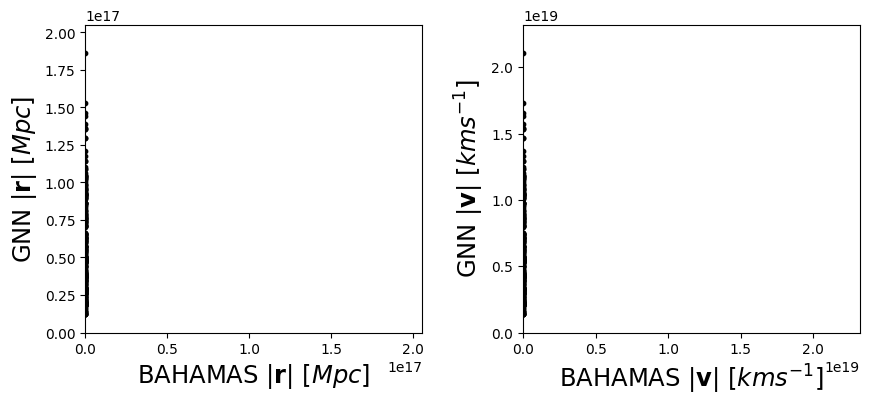

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'wspace': 0.3})

one_one = np.linspace(-10000, 10000, 100)

x_plot_pos, y_plot_pos = targets[mask, 0]* 1.25 + 2, preds[mask, 0]* 1.25 + 2

axs[0].scatter(x_plot_pos, y_plot_pos, c='k', s=10)
axs[0].plot(one_one, one_one, c='k', linestyle='--')
axs[0].set_xlabel(r'BAHAMAS $| \mathbf{r} |$ $\left[ Mpc \right]$', fontsize = 17.5)
axs[0].set_ylabel(r'GNN $| \mathbf{r} |$ $\left[ Mpc \right]$', fontsize = 17.5)
lims = np.concatenate([x_plot_pos, y_plot_pos])
axs[0].set_xlim(np.min(lims)*0.9, np.max(lims)*1.1)
axs[0].set_ylim(np.min(lims)*0.9, np.max(lims)*1.1)

x_plot_vel, y_plot_vel = targets[mask, 1]*500 + 1300, preds[mask, 1]*500 + 1300

axs[1].scatter(x_plot_vel, y_plot_vel, c='k', s=10)
axs[1].plot(one_one, one_one, c='k', linestyle='--')
axs[1].set_xlabel(r'BAHAMAS $| \mathbf{v} |$ $\left[ km s^{-1} \right]$', fontsize = 17.5)
axs[1].set_ylabel(r'GNN $| \mathbf{v} |$ $\left[ km s^{-1} \right]$', fontsize = 17.5)
lims = np.concatenate([x_plot_vel, y_plot_vel])
axs[1].set_xlim(np.min(lims)*0.9, np.max(lims)*1.1)
axs[1].set_ylim(np.min(lims)*0.9, np.max(lims)*1.1)

(array([ 10.,  40.,  58., 110., 164., 139., 112.,  50.,  14.,   3.]),
 array([-903.72924805, -445.03717041,   13.65490723,  472.34692383,
         931.0390625 , 1389.73120117, 1848.4230957 , 2307.11523438,
        2765.80737305, 3224.49926758, 3683.19189453]),
 <BarContainer object of 10 artists>)

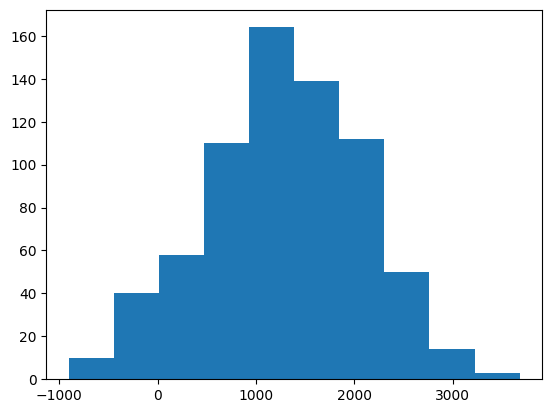

In [63]:
plt.hist(train_data['nodes'][4, :, 2] * 500 + 1300)